# Tutorial #2: Traversability Prediction Models

This tutorial briefly explains how to predict traversability for motion planning algorithms. We assume there are ten distinct terrain classes in planetary surface environments and each has a latent slip model. In order to predict traversability map, it is necessary to first identify distinct terrain types then predict individual models mapping terrain geometry to slip behaviors.

## Before starting

Before starting this tutorial, you can download [datasets and trained models](https://github.com/masafumiendo/benchnav/releases/tag/v0.0). These folders contain a dataset to train terrain classifier and slip regressors as well as pretrained ML models based on PyTorch (and GPyTorch).

- datasets: this folder contains datasets for training terrain classifiers in `train` and `valid,` and training slip regressors in `slip_models.` In the `test` folder, there are testing subsets used for motion planning environments.
- trained_models: this folder contains trained ML models. As a terrain classifier, we adopt a simple Unet. As slip regressors, we use Gaussian process regressors implemented in gpytorch.

You can download `datasets.zip` and `trained_models.zip` and place them as `./datasets` and `./trained_models` after unzipping them, respectively.

In [1]:
# Import the necessary libraries

# Add the parent directory to the path so that the environment can be found
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

# Import the necessary libraries
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from gpytorch.likelihoods import GaussianLikelihood

# Import the necessary classes
from src.prediction_models.terrain_classifiers.unet import Unet
from src.prediction_models.slip_regressors.gpr import GPModel
from src.prediction_models.traversability_predictors.classifier_and_regressor import TraversabilityPredictor
from src.prediction_models.trainers.utils import ParamsModelTraining
from src.prediction_models.trainers.utils import load_model_state_dict
from src.data.terrain_dataset import TerrainClassificationDataset as TCDataset
from src.data.terrain_dataset import TraversabilityPredictionDataset as TPDataset
from src.data.slip_models_generator import SlipModelsGenerator

sns.set()

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/endo/repos/benchnav/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Terrain Classification based on CNN

Semantic scene understanding is crucial for predicting traversability, as different material properties cause different risks of immobility. Terrain classification is performed for this purpose by taking RGB color images to categorize distince terrain types. We adopt a simple Unet as a terrain classifier and you can see how Unet conducts terrain classifications as follows.

1. Load the pretrained `Unet` from unzipped `trained_models`. The class `ParamsModelTraining` specifies training conditions of Unet.

In [2]:
num_total_terrain_classes = 10
terrain_classifier = Unet(num_total_terrain_classes).to(device)

dataset_index = 1

# Set the model directory
base_directory = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
model_directory = os.path.join(
    base_directory, f"trained_models/dataset{dataset_index:02d}/Unet/"
)

# Set the parameters for model training
params_model_training = ParamsModelTraining(
    batch_size=16,
    learning_rate=1e-3,
    weight_decay=0e00,
    num_epochs=100,
    save_interval=None,
    device=device,
)

# Load the trained model
model_directory = os.path.join(
    model_directory,
    f"bs{params_model_training.batch_size:03d}_"
    f"lr{params_model_training.learning_rate:.0e}_"
    f"wd{params_model_training.weight_decay:.0e}_"
    f"epochs{params_model_training.num_epochs:03d}",
    "models/best_model.pth",
)

terrain_classifier = load_model_state_dict(terrain_classifier, model_directory, device)

2. Load the testing dataset from unzipped `datasets` and perform terrain classification.

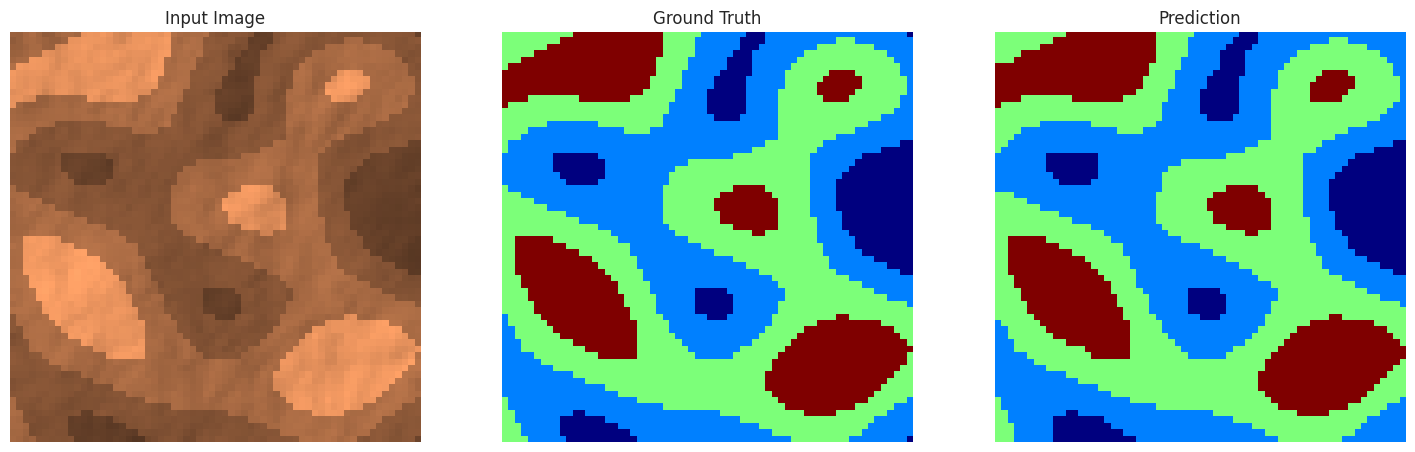

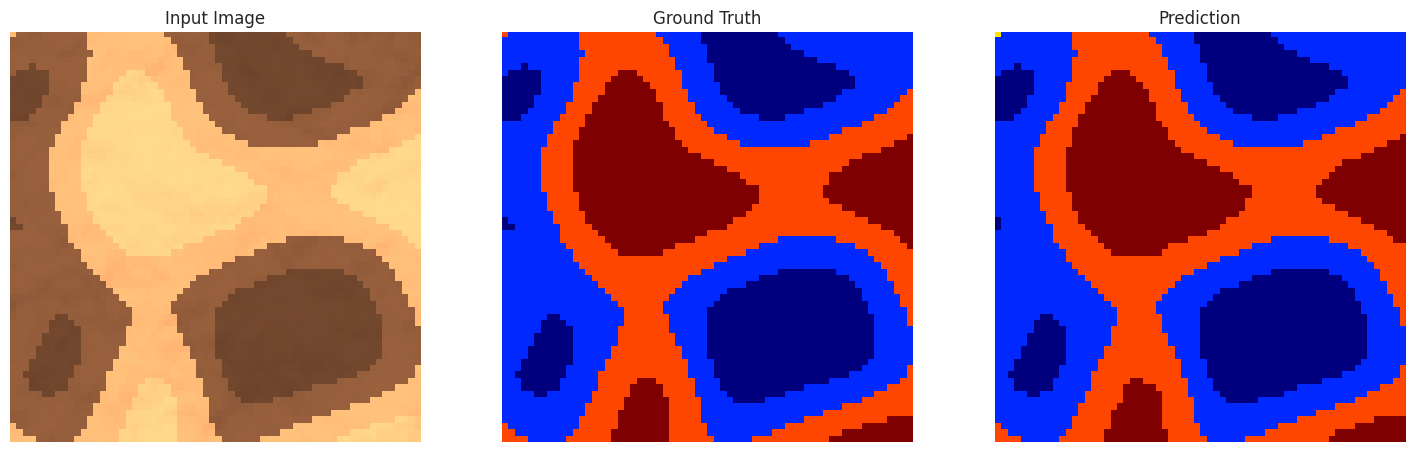

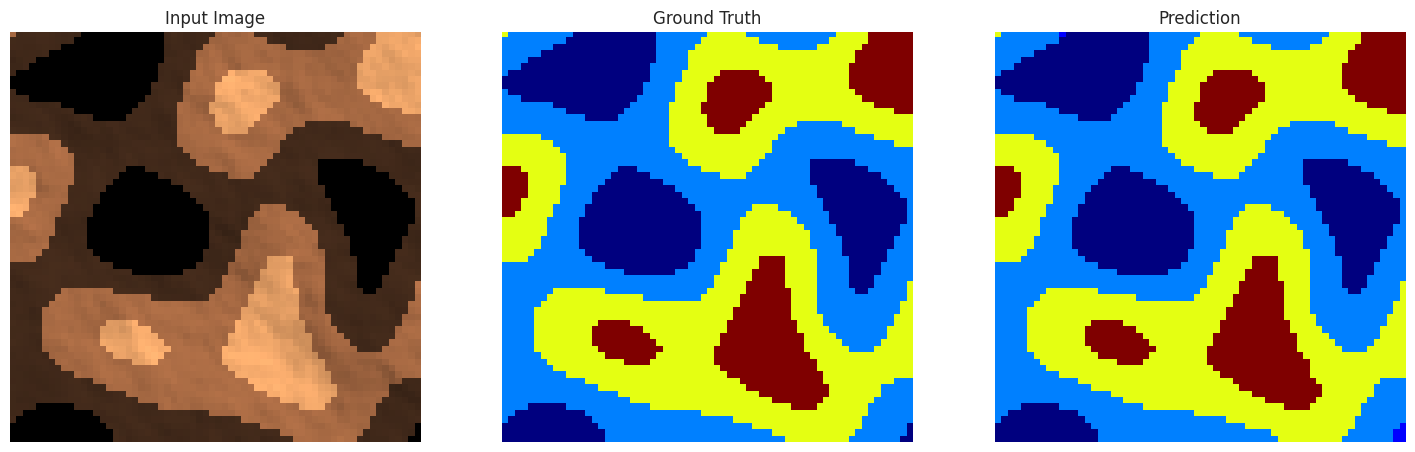

In [3]:
# Set the data directory
data_directory = os.path.join(
    base_directory, f"datasets/dataset{dataset_index:02d}/"
)
subset_index = 1

test_dataset = TCDataset(data_directory, "test", subset_index)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Test the model
for index, (colors, t_classes) in enumerate(test_loader):
    colors = colors.to(device)
    t_classes = t_classes.to(device)
    predicted = terrain_classifier.predict(colors)

    # Data conversion for visualization
    colors = colors.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    t_classes = t_classes.squeeze(0).cpu().numpy()
    predicted = predicted.squeeze(0).cpu().detach().numpy()

    # Visualization
    _, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Input Image
    axs[0].imshow(colors)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    # Ground Truth
    axs[1].imshow(t_classes, cmap="jet")
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    # Predicted
    axs[2].imshow(predicted, cmap="jet")
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    # Break the loop after some iterations
    if index == 2:
        break

plt.show()

## Slip Regression based on GPR

The primary purpose of slip regression is to project terrain geometry to slip behavior for symbolically categorized terrain classes. We use Gaussian process regressions (GPR) for this purpose, since it can not only predict nonlinear slip functions but also give us its probability distributions. This enables risk-aware decision makings such as using VaR or CVaR.

1. Load the pretrained `GPR` from unzipped `trained_models`. The class `ParamsModelTraining` specifies training conditions of GPR.

In [4]:
# Set the model directory
model_directory = os.path.join(
    base_directory, f"trained_models/dataset{dataset_index:02d}/GPR/"
)
# Set the parameters for model training
params_model_training = ParamsModelTraining(
    learning_rate=1e-1, num_iterations=100, device=device
)
model_directory = os.path.join(
    model_directory,
    f"lr{params_model_training.learning_rate:.0e}_"
    f"iters{params_model_training.num_iterations:03d}",
)

# Set the data directory
data_directory = os.path.join(
    base_directory, f"datasets/dataset{dataset_index:02d}/slip_models/"
)

all_gp_models = {}  # Dictionary to store the GP model
all_train_data = {}  # Dictionary to store the training data
for i in range(num_total_terrain_classes):
    # Load the training data
    train_data = torch.load(
        os.path.join(data_directory, f"observations/{i:02d}_class.pth")
    )
    train_x = train_data["train_x"].to(device)
    train_y = train_data["train_y"].to(device)
    # Initialize the GP model
    likelihood = GaussianLikelihood().to(device=device)
    gp_model = GPModel(train_x, train_y, likelihood).to(device)
    # Load the trained model
    gp_model = load_model_state_dict(
        gp_model,                              
        os.path.join(model_directory, f"models/{i:02d}_class.pth"), 
        device,
        )
    # Store the model
    all_gp_models[i] = gp_model
    # Store the training data
    all_train_data[i] = train_data

2. Load the actual slip models for reference. The `SlipModelsGenerator` class plays this role by replicating latent slip models for reproductivity.

In [5]:
# Load the actual model for reference
slip_sensitivity_minmax = (1.0, 9.0)
slip_nonlinearity_minmax = (1.4, 2.0)
slip_offset_minmax = (0.0, 0.1)
noise_scale_minmax = (0.1, 0.2)

# Generate the slip models
slip_models_generator = SlipModelsGenerator(
    num_total_terrain_classes=num_total_terrain_classes,
    slip_sensitivity_minmax=slip_sensitivity_minmax,
    slip_nonlinearity_minmax=slip_nonlinearity_minmax,
    slip_offset_minmax=slip_offset_minmax,
    noise_scale_minmax=noise_scale_minmax,
    device=device,
)
slip_models = slip_models_generator.generate_slip_models()

3. Visualize GPR predictions and actual slip models in order to see how GPR captures slope-slip behaviors. 

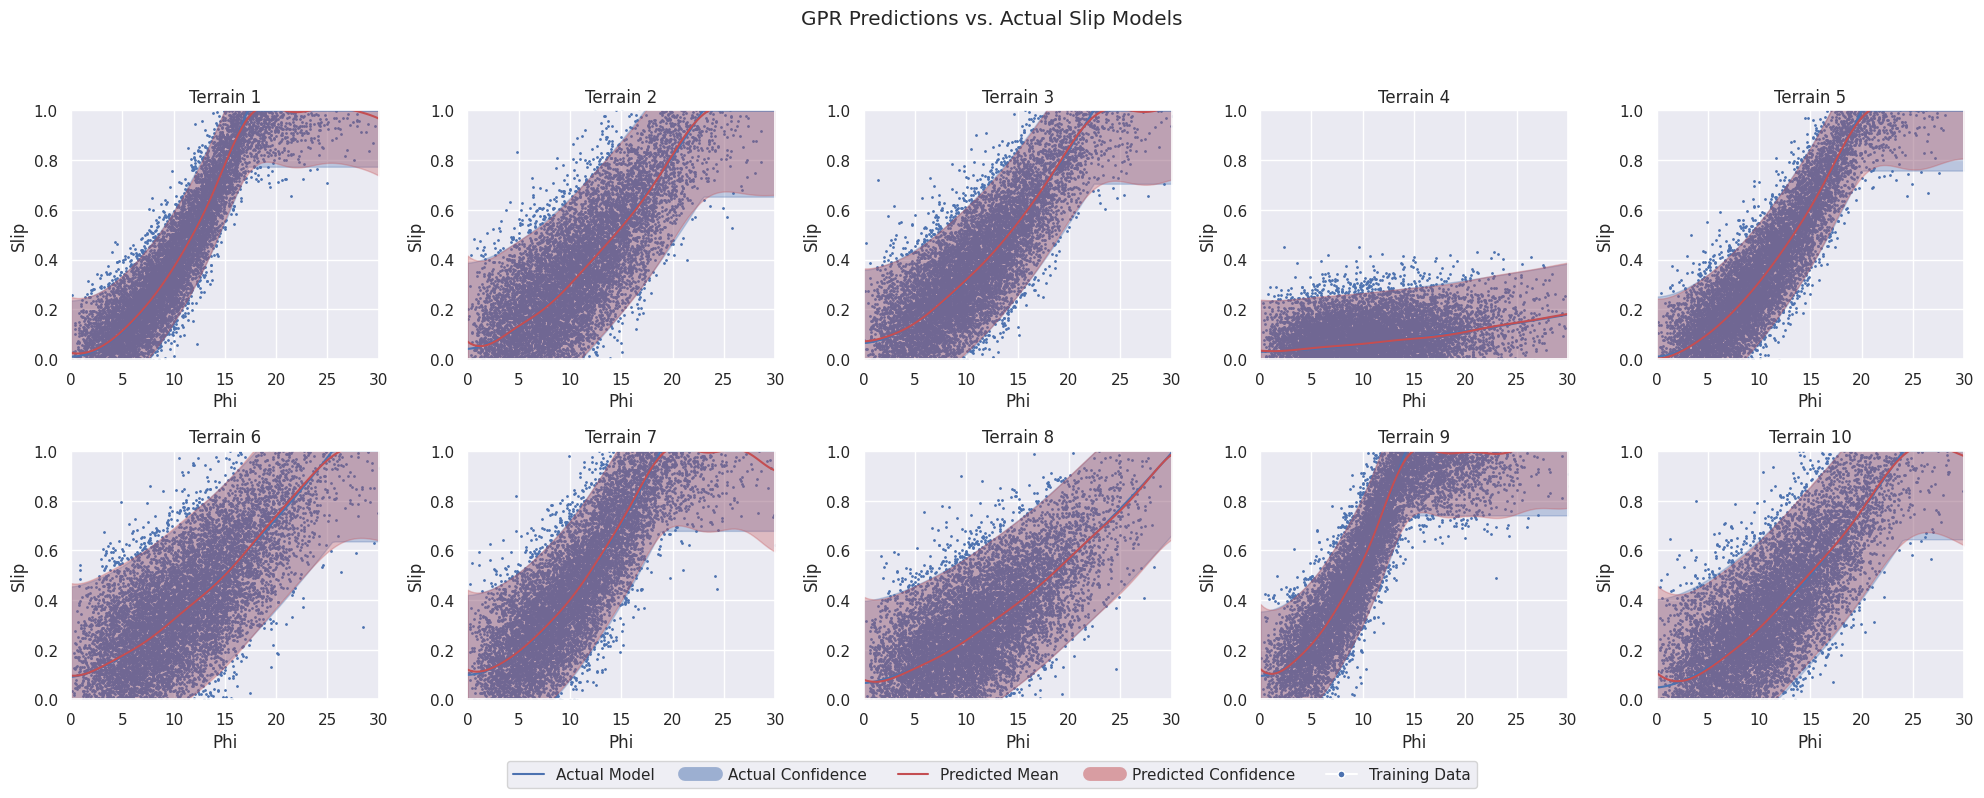

In [6]:
# Prepare figure for subplots
fig, axes = plt.subplots(
    nrows=2, ncols=5, figsize=(20, 8)
)  # Adjust nrows and ncols based on your preference
fig.suptitle("GPR Predictions vs. Actual Slip Models")

test_phis = torch.linspace(0, 30, 100).to(device=device)
for i in range(num_total_terrain_classes):
    # Test the trained GP model
    pred_dist = all_gp_models[i].predict(test_phis)
    pred_mean = pred_dist.mean
    pred_stddev = pred_dist.stddev
    # Get the lower and upper confidence bounds
    pred_lower, pred_upper = pred_mean - 2.0 * pred_stddev, pred_mean + 2.0 * pred_stddev

    # Retrieve the actual slip model
    slip_dist = slip_models[i].model_distribution(test_phis)
    slip_mean = slip_dist.mean
    slip_stddev = slip_dist.stddev
    # Get the lower and upper confidence bounds
    slip_lower, slip_upper = slip_mean - 2.0 * slip_stddev, slip_mean + 2.0 * slip_stddev

    # Retrieve training data
    train_x = all_train_data[i]["train_x"]
    train_y = all_train_data[i]["train_y"]

    # Pytorch -> Numpy
    test_phis = test_phis.cpu().numpy()
    pred_mean = pred_mean.cpu().numpy()
    pred_lower = pred_lower.cpu().numpy()
    pred_upper = pred_upper.cpu().numpy()
    slip_mean = slip_mean.cpu().numpy()
    slip_lower = slip_lower.cpu().numpy()
    slip_upper = slip_upper.cpu().numpy()
    train_x = train_x.cpu().numpy()
    train_y = train_y.cpu().numpy()

    # Visualization
    # Plot the results in a subplot
    ax = axes.flatten()[i]
    # Actual model
    ax.plot(test_phis, slip_mean, "b", label="Actual Model")
    ax.fill_between(
        test_phis,
        slip_lower,
        slip_upper,
        color="b",
        alpha=0.3,
        label="Actual Confidence",
    )
    # Training data
    ax.scatter(train_x, train_y, color="b", label="Training Data", s=1)
    # GP model
    ax.plot(test_phis, pred_mean, "r", label="Predicted Mean")
    ax.fill_between(
        test_phis,
        pred_lower,
        pred_upper,
        color="r",
        alpha=0.3,
        label="Predicted Confidence",
    )

    ax.set_title(f"Terrain {i+1}")
    ax.set_xlabel("Phi")
    ax.set_ylabel("Slip")
    ax.set_xlim([0, 30])
    ax.set_ylim([0, 1])

    # Convert the test_phis back to torch
    test_phis = torch.from_numpy(test_phis).to(device=device)

# Custom legend entries
legend_elements = [
    Line2D([0], [0], color="b", label="Actual Model"),
    Line2D([0], [0], color="b", alpha=0.5, label="Actual Confidence", linewidth=10),
    Line2D([0], [0], color="r", label="Predicted Mean"),
    Line2D(
        [0], [0], color="r", alpha=0.5, label="Predicted Confidence", linewidth=10
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Training Data",
        markerfacecolor="b",
        markersize=5,
    ),
]

# Add the global legend
fig.legend(
    handles=legend_elements, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 0.05)
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Traversability Prediction

Given the multiple ML models, now you can predict traversability that considers both terrain geometry and appearance in complex off-road environments. Such traversability prediction map can be used for later motion planning problems.

1. Set `TraversabilityPredictor` based on terrain classifer and slip regressors. You can simply provide already loaded models into the class.

In [7]:
traversability_predictor = TraversabilityPredictor(
    terrain_classifier=terrain_classifier,
    slip_regressors=all_gp_models,
    device=device,
)

2. Predict traversability by providing `colors` and `slopes` from map instances. The `predict` method returns `pred_dist` that is based on `torch.distributions.Normal` to represent probability distributions of traversability predictions.

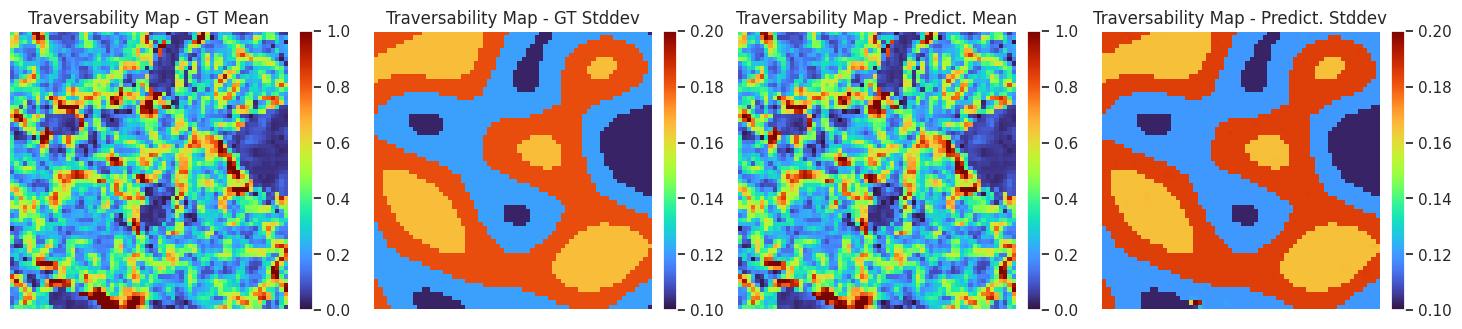

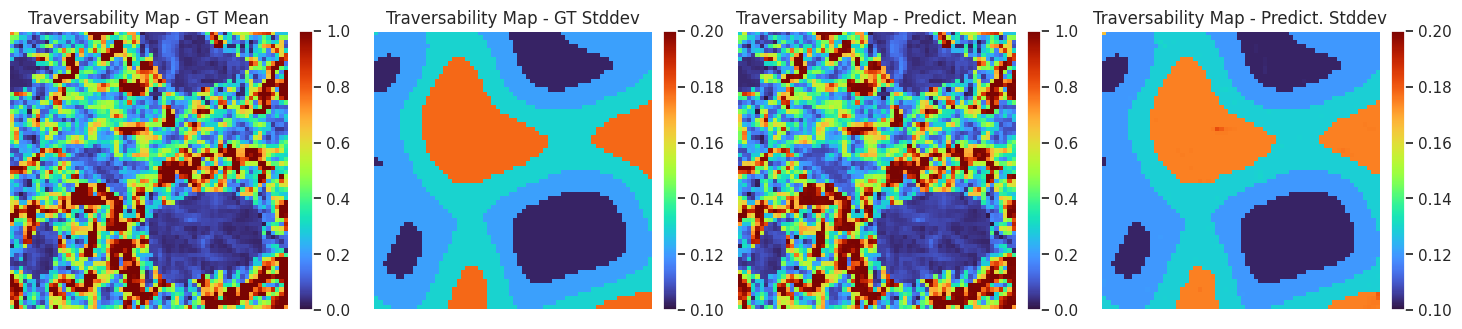

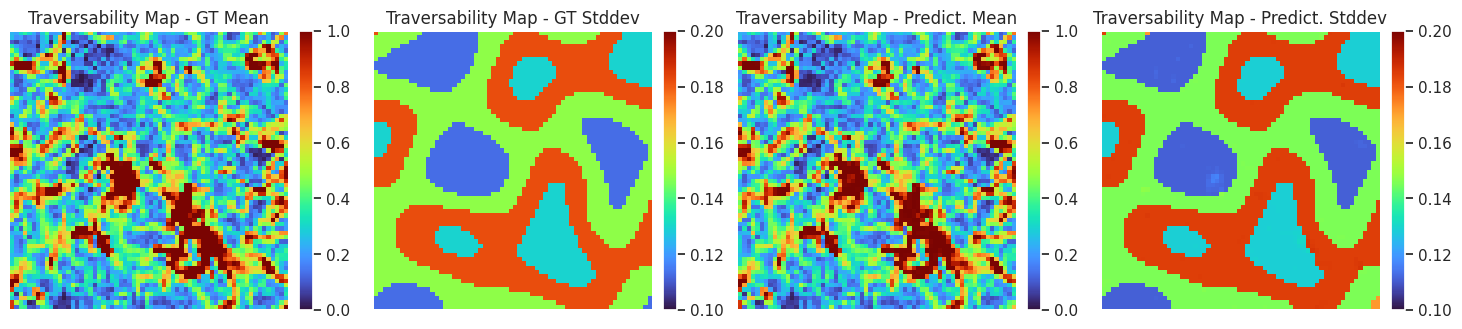

In [8]:
# Set the data directory
data_directory = os.path.join(
    base_directory, f"datasets/dataset{dataset_index:02d}/"
)
subset_index = 1

test_dataset = TPDataset(data_directory, "test", subset_index)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Test the model
for index, (colors, slopes, slips_mean, slips_stddev) in enumerate(test_loader):
    colors = colors.to(device)
    slopes = slopes.to(device)
    pred_dist = traversability_predictor.predict(colors, slopes)

    # Data conversion for visualization
    slips_mean = slips_mean.cpu().detach().numpy().squeeze(0)
    slips_stddev = slips_stddev.cpu().detach().numpy().squeeze(0)
    pred_mean = pred_dist.mean.cpu().detach().numpy().squeeze(0)
    pred_stddev = pred_dist.stddev.cpu().detach().numpy().squeeze(0)

    # Visualization
    _, axs = plt.subplots(1, 4, figsize=(18, 6))
    # mean map
    mean_img = axs[0].imshow(slips_mean, cmap="turbo", vmin=0, vmax=1)
    axs[0].set_title("Traversability Map - GT Mean")
    axs[0].axis("off")
    fig.colorbar(mean_img, ax=axs[0], orientation="vertical", fraction=0.046, pad=0.04)

    # stddev map
    stddev_img = axs[1].imshow(slips_stddev, cmap="turbo", vmin=0.1, vmax=0.2)
    axs[1].set_title("Traversability Map - GT Stddev")
    axs[1].axis("off")
    fig.colorbar(stddev_img, ax=axs[1], orientation="vertical", fraction=0.046, pad=0.04)

    mean_img = axs[2].imshow(pred_mean, cmap="turbo", vmin=0, vmax=1)
    axs[2].set_title("Traversability Map - Predict. Mean")
    axs[2].axis("off")
    fig.colorbar(mean_img, ax=axs[2], orientation="vertical", fraction=0.046, pad=0.04)

    # stddev map
    stddev_img = axs[3].imshow(pred_stddev, cmap="turbo", vmin=0.1, vmax=0.2)
    axs[3].set_title("Traversability Map - Predict. Stddev")
    axs[3].axis("off")
    fig.colorbar(stddev_img, ax=axs[3], orientation="vertical", fraction=0.046, pad=0.04)    
    
    # Break the loop after some iterations
    if index == 2:
        break

plt.show()